In [1]:
# !pip install chess
# !pip install transformers
# !pip install sentence-transformers scikit-learn umap-learn
# !brew install stockfish


In [ ]:
# Author: Kerem Kazan
# Title: Chess Commentator Transformer - Intro

In this notebook, we will go through our data and execute some light pre-processing. We will build our way up to a transformer pipeline. Our main purpose in this notebook here is to build an intuition for the data, and shaping it into a format that we can use to train a transformer network. The data used in this notebook is downloaded from https://www.freechess.org/Ladder/games.html. It's too small to train a good model - but it's basically the best publicly available data we have. We will have to mine our own data, which we will get to in the next notebook.

# Data Analysis - Comments

Avg token length: 58.69
95th percentile: 173
Max token length: 512


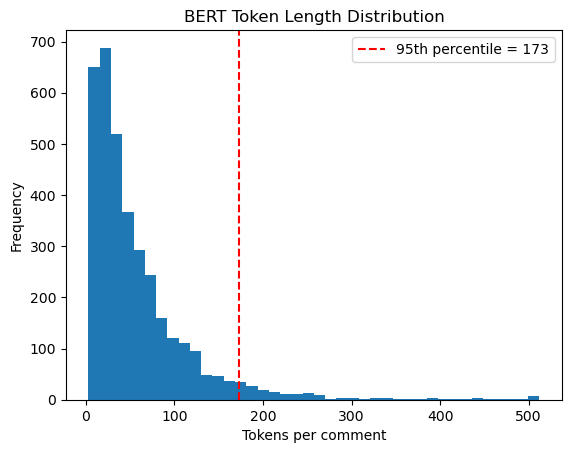

In [2]:
# Before we attempt training, let's analyze the comments dataset.

from transformers import BertTokenizer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Load comments
df = pd.read_csv('./dataset/data/freechess_annotated_positions.csv')
comments = df["comment"].dropna()

# Tokenize and get lengths
token_lengths = comments.apply(lambda c: len(tokenizer.encode(c, truncation=True, max_length=512)))

# Compute stats
avg_len = token_lengths.mean()
p95 = int(np.percentile(token_lengths, 95))
max_len = token_lengths.max()

print(f"Avg token length: {avg_len:.2f}")
print(f"95th percentile: {p95}")
print(f"Max token length: {max_len}")

# Plot distribution
plt.hist(token_lengths, bins=40)
plt.axvline(p95, color='red', linestyle='--', label=f'95th percentile = {p95}')
plt.title("BERT Token Length Distribution")
plt.xlabel("Tokens per comment")
plt.ylabel("Frequency")
plt.legend()
plt.show()


In [3]:
# Since the graph is right-skewed, we can see that most comments are short. Let's dig in more:

std_dev = token_lengths.std()
mean = token_lengths.mean()

print(f"Standard deviation: {std_dev}")
print(f"Mean: {mean}")

# The standard deviation is higher than the mean, which is expected in right-skewed distributions. Let's find p95 and p99:

p95 = int(np.percentile(token_lengths, 95))
p99 = int(np.percentile(token_lengths, 99))

print(f"95th percentile: {p95}")
print(f"99th percentile: {p99}")


Standard deviation: 62.259419100199125
Mean: 58.68853378188955
95th percentile: 173
99th percentile: 314


In [4]:
# The 99th percentile is much higher than the 95th percentile. So, let's target 95%, and truncate the rest.

target_percentile = 95 if p95 * 1.5 < p99 else 99
print(f"Ceiling: {target_percentile}")

def find_truncation_length(token_lengths, percentile=95, base=8):
    """
    Finds the smallest multiple of `base` that fits the desired percentile of token lengths.

    Args:
        token_lengths (list or np.array or pd.Series): List of tokenized sequence lengths.
        percentile (int): Percentile to cover (default is 95).
        base (int): Alignment base (e.g., 8, 16, 32, 64). Default is 8.

    Returns:
        int: Suggested truncation length.
    """
    assert 0 < percentile <= 100, "Percentile must be in (0, 100]"
    token_lengths = np.asarray(token_lengths)
    p_value = np.percentile(token_lengths, percentile)
    truncation_length = int(np.ceil(p_value / base) * base)
    return truncation_length

truncation_len = find_truncation_length(token_lengths, target_percentile, base=8)
print(find_truncation_length(token_lengths, target_percentile, base=8))

Ceiling: 95
176


Standard deviation: 45.78568968926498
Mean: 54.52985702270816
95th percentile: 173
99th percentile: 176


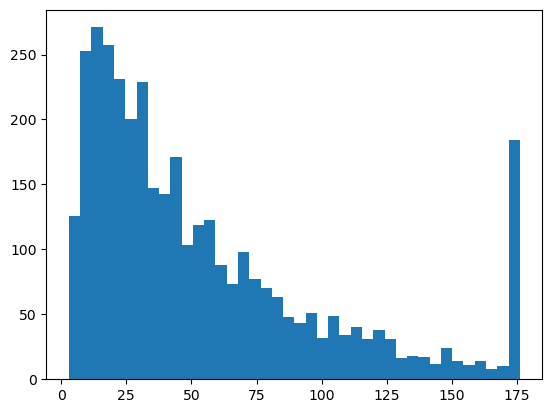

In [5]:
# Let's now tokenize with truncation, and plot the distribution again:

token_lengths_truncated = comments.apply(lambda c: len(tokenizer.encode(c, truncation=True, max_length=truncation_len)
))

plt.hist(token_lengths_truncated, bins=40)

# let's find the new stats:

std_dev = token_lengths_truncated.std()
mean = token_lengths_truncated.mean()
p95 = int(np.percentile(token_lengths_truncated, 95))
p99 = int(np.percentile(token_lengths_truncated, 99))

print(f"Standard deviation: {std_dev}")
print(f"Mean: {mean}")
print(f"95th percentile: {p95}")
print(f"99th percentile: {p99}")

# We managed to bring the standard deviation under the mean. All outliers show up all the way at the right.

# Tokenization

In [6]:
# Okay, but now we have a different problem. BERT tokenizer has a 30k vocabulary size, which is overkill for our use case. Let's train a BPE tokenizer on our dataset.

from tokenizers import Tokenizer, models, trainers, pre_tokenizers, decoders


# First, we create a tokens.txt file that contains all comments in the dataset.
comments = df["comment"].dropna()
  
with open("./dataset/data/comments.txt", "w") as f:
    for comment in comments:
        f.write(comment + "\n")

# We then train a BPE tokenizer on the tokens.txt file.

# Initialize tokenizer with empty BPE model
bpe_tokenizer = Tokenizer(models.BPE(unk_token="[UNK]"))
bpe_tokenizer.pre_tokenizer = pre_tokenizers.ByteLevel(add_prefix_space=True)
bpe_tokenizer.decoder = decoders.ByteLevel()

BPE_TRAINER_VOCAB_SIZE = 500

# Training config
bpe_trainer = trainers.BpeTrainer(vocab_size=BPE_TRAINER_VOCAB_SIZE, special_tokens=["[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]"])

# Train
bpe_tokenizer.train(files=["./dataset/data/comments.txt"], trainer=bpe_trainer)

# Now let's take it for a spin.

tokenized = bpe_tokenizer.encode("This seems the best move since it prevented Black's Bishop from coming into my king-fray Killerman: After this the game starts to slip. In the main if you look at the development now we can see why. White has overcooked the kingside pawn thrust and the knight is not developed or rooks. Rh3 is best now to try to keep a hold on things.")


print(tokenized.ids)

decoded = bpe_tokenizer.decode(tokenized.ids)
print(decoded)




[325, 281, 422, 104, 103, 363, 162, 109, 100, 228, 173, 296, 367, 86, 131, 225, 227, 142, 229, 389, 489, 115, 445, 81, 210, 261, 15, 72, 84, 209, 246, 206, 119, 497, 28, 213, 320, 181, 104, 257, 109, 174, 84, 86, 85, 116, 109, 78, 75, 82, 16, 449, 104, 111, 67, 100, 310, 136, 369, 194, 104, 352, 364, 305, 249, 237, 281, 148, 91, 16, 252, 278, 110, 231, 69, 294, 131, 104, 261, 331, 166, 99, 84, 339, 137, 104, 270, 129, 204, 352, 131, 284, 302, 85, 16, 247, 74, 21, 129, 103, 363, 305, 116, 424, 116, 158, 486, 98, 113, 81, 161, 150, 99, 115, 85, 16]
 This seems the best move since it prevented Black's Bishop from coming into my king-fray Killerman: After this the game starts to slip. In the main if you look at the development now we can see why. White has overcooked the kingside pawn thrust and the knight is not developed or rooks. Rh3 is best now to try to keep a hold on things.


Mean: 85.91365292963275
Standard deviation: 100.1590202329096
Max token length: 1104
95th percentile: 255
99th percentile: 496


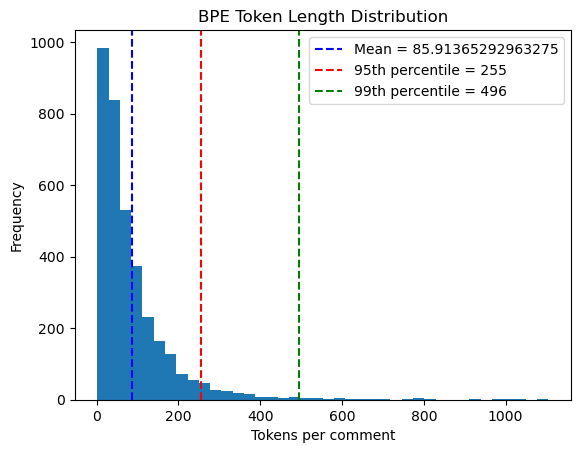

In [7]:
# Now let's run the same analysis again:

token_lengths = comments.apply(lambda c: len(bpe_tokenizer.encode(c, add_special_tokens=True).ids))

mean = token_lengths.mean()
max_len = token_lengths.max()
std_dev = token_lengths.std()
p95 = int(np.percentile(token_lengths, 95))
p99 = int(np.percentile(token_lengths, 99))

print(f"Mean: {mean}")
print(f"Standard deviation: {std_dev}")
print(f"Max token length: {max_len}")
print(f"95th percentile: {p95}")
print(f"99th percentile: {p99}")

# Let's visualize the distribution:

plt.hist(token_lengths, bins=40)
plt.axvline(mean, color='blue', linestyle='--', label=f'Mean = {mean}')
plt.axvline(p95, color='red', linestyle='--', label=f'95th percentile = {p95}')
plt.axvline(p99, color='green', linestyle='--', label=f'99th percentile = {p99}')
plt.title("BPE Token Length Distribution")
plt.xlabel("Tokens per comment")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [8]:
# Compared to bert-base-uncased, the token lengths are much higher - but that's due to the reduced vocabulary size.
# Now let's run the same truncation technique again:

target_percentile = 95 if p95 * 1.5 < p99 else 99
print(f"Ceiling: {target_percentile}")

truncation_len = find_truncation_length(token_lengths, target_percentile, base=8)
print(f"Suggested truncation length: {truncation_len}")

Ceiling: 95
Suggested truncation length: 256


Mean: 78.37594617325483
Standard deviation: 68.02692147996163
Max token length: 256
95th percentile: 255
99th percentile: 256


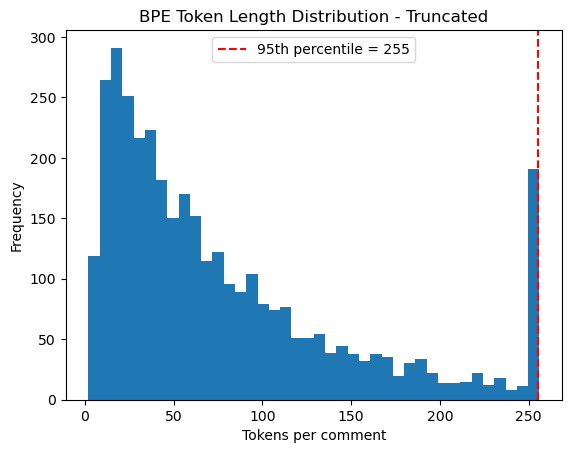

In [9]:
# Luckily, our suggested truncation length is not that much higher than bert's. So let's truncate the comments again:

bpe_tokenizer.enable_truncation(max_length=truncation_len)

token_lengths_truncated = comments.apply(lambda c: len(bpe_tokenizer.encode(c).ids))

mean = token_lengths_truncated.mean()
max_len = token_lengths_truncated.max()
std_dev = token_lengths_truncated.std()
p95 = int(np.percentile(token_lengths_truncated, 95))
p99 = int(np.percentile(token_lengths_truncated, 99))

print(f"Mean: {mean}")
print(f"Standard deviation: {std_dev}")
print(f"Max token length: {max_len}")
print(f"95th percentile: {p95}")
print(f"99th percentile: {p99}")

# Let's visualize the distribution:

plt.hist(token_lengths_truncated, bins=40)
plt.axvline(p95, color='red', linestyle='--', label=f'95th percentile = {p95}')
plt.title("BPE Token Length Distribution - Truncated")
plt.xlabel("Tokens per comment")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# Once again, we now have a slightly left-skewed distribution. And the good news is our encoder-decoder network should now have 256 * 500 = 128k features on the output layer, instead of 5.3M.

In [10]:
# Now let's enable padding before we create a dataset:

bpe_tokenizer.enable_padding(
  pad_id=bpe_tokenizer.token_to_id("[PAD]"), 
  pad_token="[PAD]", 
  length=truncation_len
)

token_lengths_padded = comments.apply(lambda c: len(bpe_tokenizer.encode(c).ids))

mean = token_lengths_padded.mean()
max_len = token_lengths_padded.max()
std_dev = token_lengths_padded.std()
p95 = int(np.percentile(token_lengths_padded, 95))
p99 = int(np.percentile(token_lengths_padded, 99))

print(f"Mean: {mean}")
print(f"Standard deviation: {std_dev}")
print(f"Max token length: {max_len}")
print(f"95th percentile: {p95}")
print(f"99th percentile: {p99}")


Mean: 256.0
Standard deviation: 0.0
Max token length: 256
95th percentile: 256
99th percentile: 256


In [11]:
# Perfect - zero standard deviation - since everything is the same length now. Let's try an example:

comment = "This seems the best move since it prevented Black's Bishop from coming into my king-fray Killerman: After this the game starts to slip. In the main if you look at the development now we can see why. White has overcooked the kingside pawn thrust and the knight is not developed or rooks. Rh3 is best now to try to keep a hold on things."
print("Before encoding:")
print(comment)

tokenized = bpe_tokenizer.encode(comment)

print("Token ids:")
print(tokenized.ids)

print("Attention mask:")
print(tokenized.attention_mask)

decoded = bpe_tokenizer.decode(tokenized.ids)
print("Decoded:")
print(decoded)

# Great, now we're seeing zero padding, and the attention mask is showing zeros where the padding is.

Before encoding:
This seems the best move since it prevented Black's Bishop from coming into my king-fray Killerman: After this the game starts to slip. In the main if you look at the development now we can see why. White has overcooked the kingside pawn thrust and the knight is not developed or rooks. Rh3 is best now to try to keep a hold on things.
Token ids:
[325, 281, 422, 104, 103, 363, 162, 109, 100, 228, 173, 296, 367, 86, 131, 225, 227, 142, 229, 389, 489, 115, 445, 81, 210, 261, 15, 72, 84, 209, 246, 206, 119, 497, 28, 213, 320, 181, 104, 257, 109, 174, 84, 86, 85, 116, 109, 78, 75, 82, 16, 449, 104, 111, 67, 100, 310, 136, 369, 194, 104, 352, 364, 305, 249, 237, 281, 148, 91, 16, 252, 278, 110, 231, 69, 294, 131, 104, 261, 331, 166, 99, 84, 339, 137, 104, 270, 129, 204, 352, 131, 284, 302, 85, 16, 247, 74, 21, 129, 103, 363, 305, 116, 424, 116, 158, 486, 98, 113, 81, 161, 150, 99, 115, 85, 16, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [12]:
# Let's now create a helper function to tokenize a comment:

import torch

def comment_to_tokenized(comment: str, tokenizer, max_tokens: int) -> dict:
    """
    Tokenizes the comment string into input_ids and attention_mask tensors.
    """
    encoded = tokenizer.encode(comment)
    return {
        "input_ids": torch.tensor(encoded.ids, dtype=torch.long),
        "attention_mask": torch.tensor(encoded.attention_mask, dtype=torch.long)
    }

# Finally, let's encode + decode a comment from the dataset:
comment = "This seems the best move since it prevented Black's Bishop from coming into my king-fray Killerman: After this the game starts to slip. In the main if you look at the development now we can see why. White has overcooked the kingside pawn thrust and the knight is not developed or rooks. Rh3 is best now to try to keep a hold on things."

tokenized = comment_to_tokenized(comment, bpe_tokenizer, truncation_len)
print(tokenized)
print(len(tokenized["input_ids"]))

decoded = bpe_tokenizer.decode(tokenized["input_ids"].tolist())
print(decoded)


{'input_ids': tensor([325, 281, 422, 104, 103, 363, 162, 109, 100, 228, 173, 296, 367,  86,
        131, 225, 227, 142, 229, 389, 489, 115, 445,  81, 210, 261,  15,  72,
         84, 209, 246, 206, 119, 497,  28, 213, 320, 181, 104, 257, 109, 174,
         84,  86,  85, 116, 109,  78,  75,  82,  16, 449, 104, 111,  67, 100,
        310, 136, 369, 194, 104, 352, 364, 305, 249, 237, 281, 148,  91,  16,
        252, 278, 110, 231,  69, 294, 131, 104, 261, 331, 166,  99,  84, 339,
        137, 104, 270, 129, 204, 352, 131, 284, 302,  85,  16, 247,  74,  21,
        129, 103, 363, 305, 116, 424, 116, 158, 486,  98, 113,  81, 161, 150,
         99, 115,  85,  16,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   

# Chess Board and Moves

In [13]:
# FEN is a standard notation for describing a chess board. It is not a good format for training a model. For this reason, we first convert the FEN to a token grid.

import chess

def fen_to_token_grid(fen: str) -> list[list[str]]:
    board = chess.Board(fen)
    token_grid = []
    for rank in range(8, 0, -1):
        row = []
        for file in range(8):
            square = chess.square(file, rank - 1)
            piece = board.piece_at(square)
            if piece:
                color = 'w' if piece.color == chess.WHITE else 'b'
                token = color + piece.symbol().lower()
            else:
                token = '.'
            row.append(token)
        token_grid.append(row)
    return token_grid

In [14]:
import torch

# We then convert the token grid to a one-hot encoded tensor.

# Define vocabulary and mapping
PIECE_VOCAB = [
    ".",  # empty
    "wp", "wr", "wn", "wb", "wq", "wk",
    "bp", "br", "bn", "bb", "bq", "bk"
]
token_to_idx = {token: idx for idx, token in enumerate(PIECE_VOCAB)}

def fen_to_onehot(fen: str) -> torch.Tensor:
    token_grid = fen_to_token_grid(fen)
    grid_indices = [[token_to_idx[token] for token in row] for row in token_grid]
    grid_tensor = torch.tensor(grid_indices, dtype=torch.long)  # shape: (8, 8)
    onehot = torch.nn.functional.one_hot(grid_tensor, num_classes=len(PIECE_VOCAB))
    return onehot.float()  # shape: (8, 8, 13)

In [ ]:
# UCI is a standard notation for describing a chess move. Just like FEN, it is not a good format for training a model. For this reason, we convert the UCI to a move tensor. This particular implementation numbers every cell from 0 to 63. It's simple, but it does not necessarily encode spatial information. We will get back to this and improve it.

import torch

def uci_to_flat_move_tensor(uci: str) -> torch.Tensor:
    """
    Converts a UCI string to a move tensor: [from_square, to_square, promotion_or_-1]
    """
    move = chess.Move.from_uci(uci)
    return torch.tensor([
        move.from_square,
        move.to_square,
        move.promotion if move.promotion is not None else -1
    ], dtype=torch.float32)

In [16]:
from typing import List, Dict
uci_to_flat_move_tensor
from tqdm import tqdm
import pandas as pd

# This function puts everything together.

def csv_to_tensors(
    csv_path: str,
    tokenizer,
    max_tokens: int
) -> List[Dict[str, torch.Tensor]]:
    df = pd.read_csv(csv_path)
    rows = []

    for _, row in tqdm(df.iterrows(), total=len(df), desc="Preprocessing"):
      item = {
          "board": fen_to_onehot(row["fen"]),
          "move": uci_to_flat_move_tensor(row["uci"]),

          #inputs_ids, attention_mask
          **comment_to_tokenized(row["comment"], tokenizer, max_tokens),

          "debug": {
            "fen": row["fen"],
            "uci": row["uci"],
            "comment": row["comment"]
          }
      }
      rows.append(item)

    return rows

In [17]:
# Let's call our csv_to_tensors function and finish our last step before creating a dataset class:

ANNOTATED_CSV_PATH = "./dataset/data/annotated_positions.csv"

data = csv_to_tensors(
  csv_path=ANNOTATED_CSV_PATH,
  tokenizer=bpe_tokenizer,
  max_tokens=truncation_len
)

Preprocessing:   0%|          | 0/3567 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Preprocessing: 100%|██████████| 3567/3567 [00:00<00:00, 3707.95it/s]


# Dataset and DataLoader

In [18]:
# Now, let's put together a simple dataset class:

from torch.utils.data import Dataset

class ChessDataset(Dataset):
    def __init__(self, data: List[Dict[str, torch.Tensor]]):
        """
        Args:
            data: A list of dicts with keys:
                - 'board': Tensor of shape (8, 8, 13)
                - 'move': Tensor of shape (3,)
                - 'input_ids': Tensor of shape (max_tokens,)
                - 'attention_mask': Tensor of shape (max_tokens,)
        """
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [19]:
import chess
import chess.engine
from IPython.display import display, HTML



from typing import List, Dict
from torch.utils.data import DataLoader
import torch

BATCH_SIZE = 16

# Create DataLoaders for training and validation
def get_dataloaders(train_data, val_data, batch_size=BATCH_SIZE):
    train_dataset = ChessDataset(train_data)
    val_dataset = ChessDataset(val_data)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader

def visualize_board_before_after(fen_string, move_string):
    board_before = chess.Board(fen_string)
    board_after = chess.Board(fen_string)
    move = chess.Move.from_uci(move_string)
    board_after.push(move)

    # Display boards side by side
    display(HTML("<div>"))
    display("")
    display(board_before)
    display(board_after)
    display(HTML("</div>"))

# Inspect one batch
def inspect_batch(dataloader):
    for batch in dataloader:
        print(f"board shape: {batch['board'].shape}, dtype: {batch['board'].dtype}")              
        print(f"move shape: {batch['move'].shape}, dtype: {batch['move'].dtype}")               
        print(f"input_ids shape: {batch['input_ids'].shape}, dtype: {batch['input_ids'].dtype}")     
        print(f"attention_mask shape: {batch['attention_mask'].shape}, dtype: {batch['attention_mask'].dtype}")
        
        print("\n")

        fen_string = batch["debug"]["fen"][0]
        move_string = batch["debug"]["uci"][0]
        print(batch["debug"]["comment"][0])
        print(move_string)
        visualize_board_before_after(fen_string, move_string)
       
        break


Inspecting train batch:
Train batch length:  201
board shape: torch.Size([16, 8, 8, 13]), dtype: torch.float32
move shape: torch.Size([16, 3]), dtype: torch.float32
input_ids shape: torch.Size([16, 256]), dtype: torch.int64
attention_mask shape: torch.Size([16, 256]), dtype: torch.int64


Nothing else will work for Black.
f4e5


''

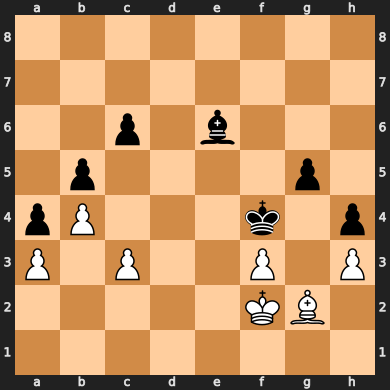

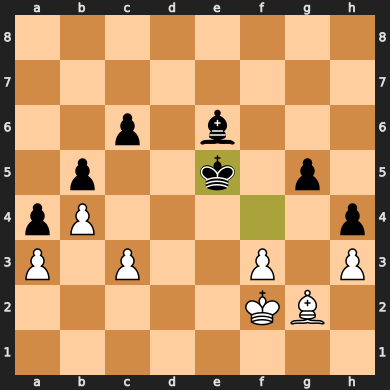

Inspecting val batch:
Val batch length:  23
board shape: torch.Size([16, 8, 8, 13]), dtype: torch.float32
move shape: torch.Size([16, 3]), dtype: torch.float32
input_ids shape: torch.Size([16, 256]), dtype: torch.int64
attention_mask shape: torch.Size([16, 256]), dtype: torch.int64


What attacks could I have launched on him when I held the initiative briefly. What were his major weaknesses? Thanks for all your help. JohnSansTerre checkmated teseo: Check http://www.chesscafe.com, the section called Novice Nook, by Dan Heisman. Interesting reading.
d5f7


''

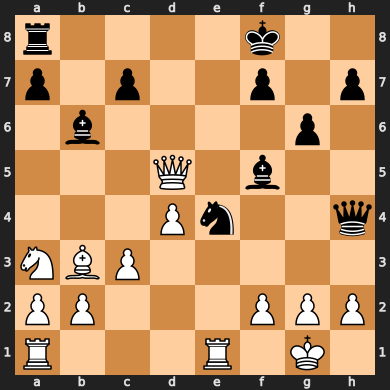

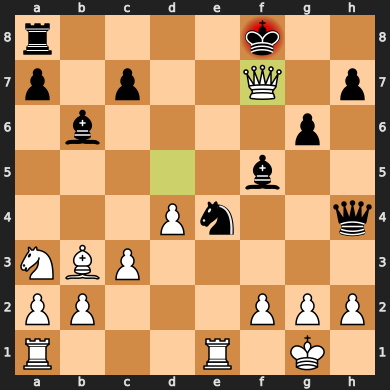

In [20]:
from sklearn.model_selection import train_test_split

train_data, val_data = train_test_split(data, test_size=0.1, random_state=42)
train_loader, val_loader = get_dataloaders(train_data, val_data)

print("Inspecting train batch:")
print("Train batch length: ", len(train_loader))
inspect_batch(train_loader)
print("Inspecting val batch:")
print("Val batch length: ", len(val_loader))
inspect_batch(val_loader)


In [ ]:
# The warmup is complete. The real fun starts in the next notebook.